In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0012706.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0010192.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0010017.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0013000.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0013166.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0003308.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0012332.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0014291.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0014729.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0000012.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0012855.jpg
/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/ISIC_0012789.jpg
/kaggle/input/isic2018/ISIC2

In [7]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [9]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [10]:
filelist_trainx = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1_Training_GroundTruth/*.png'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

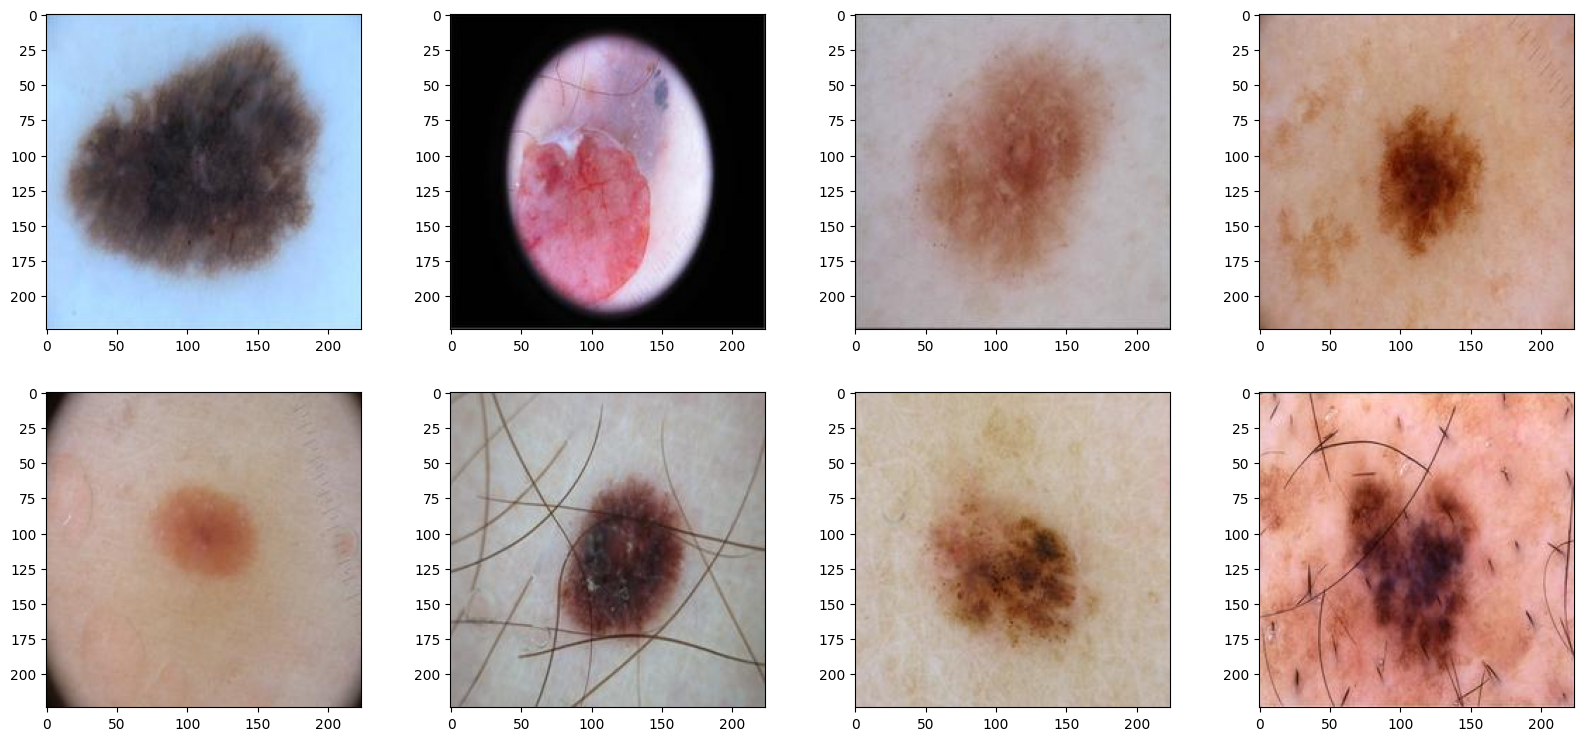

In [5]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

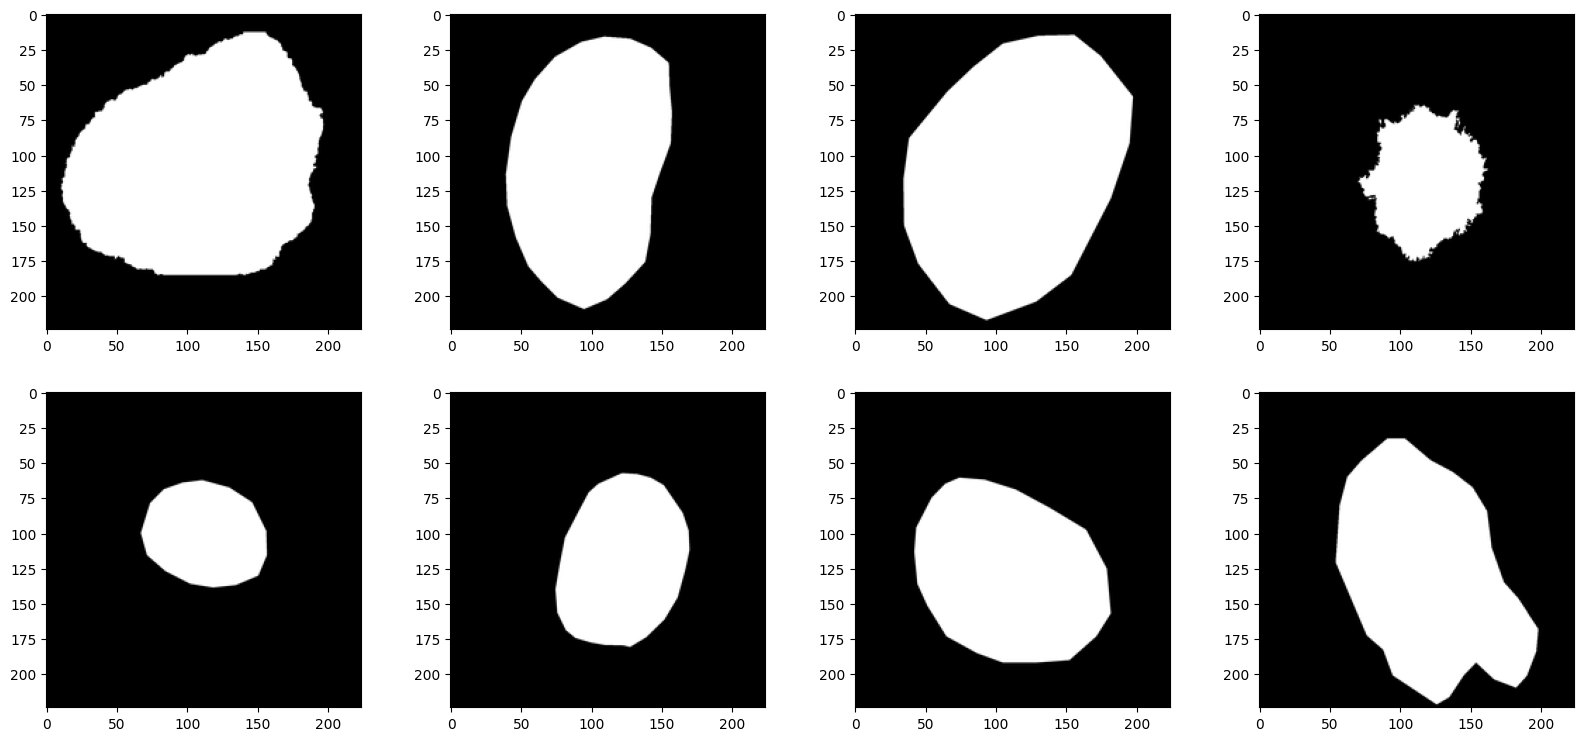

In [7]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

In [11]:
filelist_trainx = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Test_Input/*.jpg'), key=numericalSort)
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('//kaggle/input/another/another/ISIC2018_Task1_Test_GroundTruth/*.png'), key=numericalSort)
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [26]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [12]:
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [13]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [14]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [15]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [16]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [17]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [18]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [19]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(X_train, Y_train)

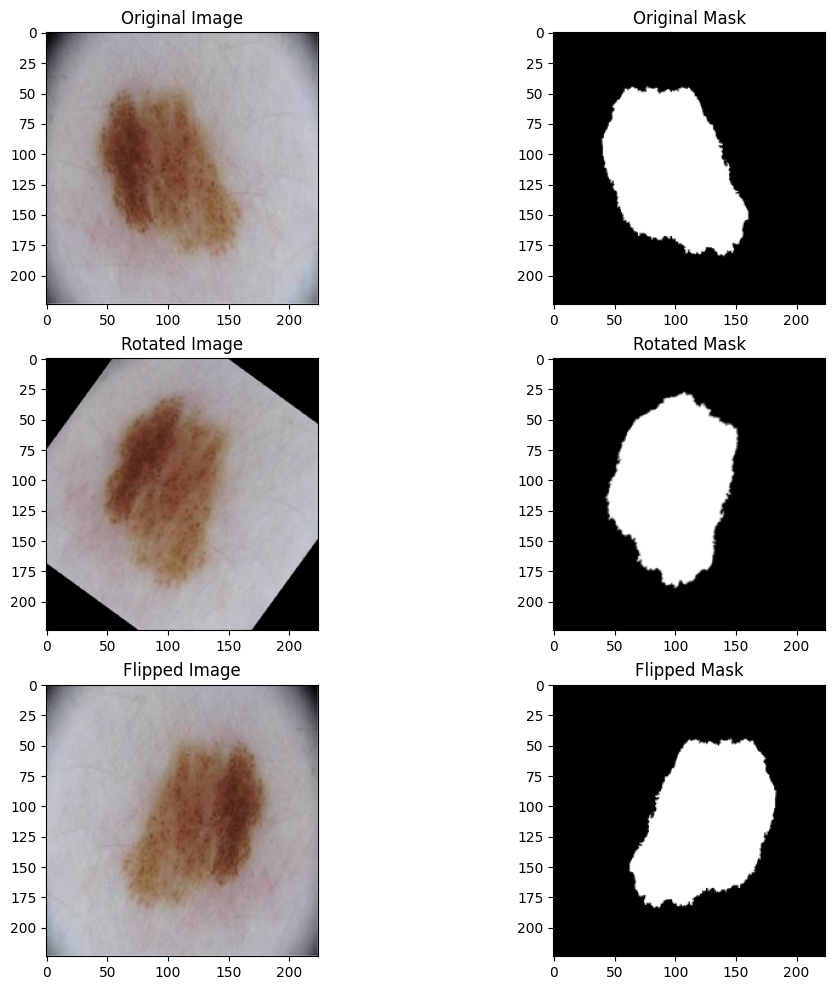

In [18]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(X_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(Y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [20]:
x_train_full = np.concatenate([X_train, x_rotated, x_flipped])
y_train_full = np.concatenate([Y_train, y_rotated, y_flipped])

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [22]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(X_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 6225
Length of the Test Set       : 1000
Length of the Validation Set : 1557


In [3]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [23]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save('/kaggle/working/' + savename)
    return model, hist

In [24]:
model, hist = UNET_224(1, 'unet_1_epoch.keras')

Model: "UNET_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 224, 224,  │          0 │ activation_1[0][… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 112, 112,  │          0 │ activation_3[0][… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ spatial_dropout2

 Total params: 31,466,753 (120.04 MB)

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

2024-04-28 09:57:15.943792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 4.85241, expected 3.99591
2024-04-28 09:57:15.943848: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 7.11791, expected 6.26141
2024-04-28 09:57:15.943857: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 7.22171, expected 6.36521
2024-04-28 09:57:15.943865: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 6.92082, expected 6.06432
2024-04-28 09:57:15.943873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 6.65139, expected 5.7949
2024-04-28 09:57:15.943881: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 6.62069, expected 5.7642
2024-04-28 09:57:15.943889: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 6.58323, expected 5.72673
2024-04-28 09:57:15.94

345/346 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7295 - dice_coe: 0.4488 - iou: 0.4193 - loss: 0.5807 - precision: 5309036544.0000 - recall: 0.9365

2024-04-28 09:59:07.118371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.53173, expected 3.64863
2024-04-28 09:59:07.118431: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.90679, expected 5.02369
2024-04-28 09:59:07.118441: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 7.34085, expected 6.45775
2024-04-28 09:59:07.118449: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.00665, expected 5.12355
2024-04-28 09:59:07.118456: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.66198, expected 4.77889
2024-04-28 09:59:07.118464: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 7.31979, expected 6.43669
2024-04-28 09:59:07.118472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.88499, expected 5.00189
2024-04-28 09:59:07.118479:

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7296 - dice_coe: 0.4482 - iou: 0.4194 - loss: 0.5806 - precision: 5332972032.0000 - recall: 0.9363

2024-04-28 09:59:53.316896: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.86253, expected 3.13968
2024-04-28 09:59:53.316960: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.98268, expected 4.25984
2024-04-28 09:59:53.316970: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.71021, expected 4.98737
2024-04-28 09:59:53.316978: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.73831, expected 5.01546
2024-04-28 09:59:53.316985: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.02175, expected 4.2989
2024-04-28 09:59:53.316993: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.89295, expected 4.17011
2024-04-28 09:59:53.317001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.84684, expected 4.124
2024-04-28 09:59:53.317009: E external/local_xla/xla/servi

346/346 ━━━━━━━━━━━━━━━━━━━━ 189s 354ms/step - accuracy: 0.7297 - dice_coe: 0.4476 - iou: 0.4195 - loss: 0.5805 - precision: 5356769792.0000 - recall: 0.9361 - val_accuracy: 0.7771 - val_dice_coe: 0.0222 - val_iou: 0.4584 - val_loss: 0.5416 - val_precision: 1885911252992.0000 - val_recall: 0.9393


In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, Reshape
from tensorflow.keras.optimizers import Adam

dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)


In [26]:
model_0 = Model(inputs, pred, name="UNET_224")
model_0.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])

In [27]:
model_0.load_weights('/kaggle/working/unet_1_epoch.keras')

In [28]:

print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(X_test, Y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

346/346 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.7702 - dice_coe: 0.0222 - iou: 0.4446 - loss: 0.5554 - precision: 1950534860800.0000 - recall: 0.9386
________________________
IOU:       |   44.88  |
Dice Coef: |   2.22  |
Precision: |   193304893849600.00  |
Recall:    |   93.92  |
Accuracy:  |   77.23  |
Loss:      |   55.12  |
________________________

-------------On Test  Set--------------------------

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7117 - dice_coe: 0.0265 - iou: 0.3650 - loss: 0.6350 - precision: 2473252618240.0000 - recall: 0.9489

2024-04-28 10:01:54.608407: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.44023, expected 3.56217
2024-04-28 10:01:54.608468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.72784, expected 5.84979
2024-04-28 10:01:54.608478: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.1489, expected 6.27084
2024-04-28 10:01:54.608486: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.06006, expected 6.182
2024-04-28 10:01:54.608494: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.53803, expected 5.65998
2024-04-28 10:01:54.608502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.15196, expected 6.27391
2024-04-28 10:01:54.608510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.05401, expected 5.17595
2024-04-28 10:01:54.608518: E external/local_xla/xla/servi

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.7115 - dice_coe: 0.0264 - iou: 0.3649 - loss: 0.6351 - precision: 2473713205248.0000 - recall: 0.9487
________________________
IOU:       |   36.28  |
Dice Coef: |   2.49  |
Precision: |   248637738188800.00  |
Recall:    |   94.39  |
Accuracy:  |   70.60  |
Loss:      |   63.72  |
________________________

-------------On validation Set---------------------

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7888 - dice_coe: 0.0226 - iou: 0.4757 - loss: 0.5243 - precision: 1792797573120.0000 - recall: 0.9380
________________________
IOU:       |   45.84  |
Dice Coef: |   2.22  |
Precision: |   188591125299200.00  |
Recall:    |   93.93  |
Accuracy:  |   77.71  |
Loss:      |   54.16  |
________________________


In [ ]:
model, hist = UNET_224(epochs_num= 50, savename= 'unet_50_epoch.keras')

Model: "UNET_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_46[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 224, 224,  │          0 │ activation_47[0]… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 112, 112,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_48[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 112, 112,  │          0 │ activation_49[0]… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 56, 56,    │          0 │ spatial_dropout2

 Total params: 31,466,753 (120.04 MB)

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 140s 285ms/step - accuracy: 0.7269 - dice_coe: 0.6822 - iou: 0.4177 - loss: 0.5823 - precision: 4.1569 - recall: 0.9659 - val_accuracy: 0.7529 - val_dice_coe: 0.2961 - val_iou: 0.4585 - val_loss: 0.5415 - val_precision: 4.5588 - val_recall: 0.9497
Epoch 2/50
 99/346 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.7507 - dice_coe: 0.2495 - iou: 0.4421 - loss: 0.5579 - precision: 6.3150 - recall: 0.8460

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, Reshape
from tensorflow.keras.optimizers import Adam

dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)


NameError: name 'K' is not defined

In [27]:
model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer= Adam(learning_rate = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])


In [28]:
model_1.load_weights('/kaggle/input/unet-isic2018/unet_50_epoch.keras')

In [30]:

print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(X_test, Y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

346/346 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.7165 - dice_coe: 1.2952 - iou: 0.4460 - loss: 0.5540 - precision: 0.8305 - recall: 0.7191
________________________
IOU:       |   45.01  |
Dice Coef: |   129.64  |
Precision: |   83.03  |
Recall:    |   71.99  |
Accuracy:  |   71.90  |
Loss:      |   54.99  |
________________________

-------------On Test  Set--------------------------

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6456 - dice_coe: 1.2170 - iou: 0.3666 - loss: 0.6334 - precision: 0.7987 - recall: 0.6671

2024-05-05 17:02:23.532409: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.44023, expected 3.56217
2024-05-05 17:02:23.532469: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.72784, expected 5.84979
2024-05-05 17:02:23.532478: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.1489, expected 6.27084
2024-05-05 17:02:23.532492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.06006, expected 6.182
2024-05-05 17:02:23.532500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.53803, expected 5.65998
2024-05-05 17:02:23.532508: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.15196, expected 6.27391
2024-05-05 17:02:23.532516: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.05401, expected 5.17595
2024-05-05 17:02:23.532523: E external/local_xla/xla/servi

56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.6455 - dice_coe: 1.2141 - iou: 0.3665 - loss: 0.6335 - precision: 0.7990 - recall: 0.6656
________________________
IOU:       |   36.44  |
Dice Coef: |   113.17  |
Precision: |   80.63  |
Recall:    |   62.34  |
Accuracy:  |   64.40  |
Loss:      |   63.56  |
________________________

-------------On validation Set---------------------

86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7374 - dice_coe: 1.2670 - iou: 0.4774 - loss: 0.5226 - precision: 0.8167 - recall: 0.7078

2024-05-05 17:02:46.195303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.86253, expected 3.13968
2024-05-05 17:02:46.195369: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.98268, expected 4.25984
2024-05-05 17:02:46.195379: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.71021, expected 4.98737
2024-05-05 17:02:46.195388: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.73831, expected 5.01546
2024-05-05 17:02:46.195396: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.02175, expected 4.2989
2024-05-05 17:02:46.195404: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.89295, expected 4.17011
2024-05-05 17:02:46.195411: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.84684, expected 4.124
2024-05-05 17:02:46.195419: E external/local_xla/xla/servi

87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.7371 - dice_coe: 1.2673 - iou: 0.4770 - loss: 0.5230 - precision: 0.8168 - recall: 0.7079
________________________
IOU:       |   45.96  |
Dice Coef: |   127.84  |
Precision: |   82.11  |
Recall:    |   71.11  |
Accuracy:  |   72.37  |
Loss:      |   54.04  |
________________________


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


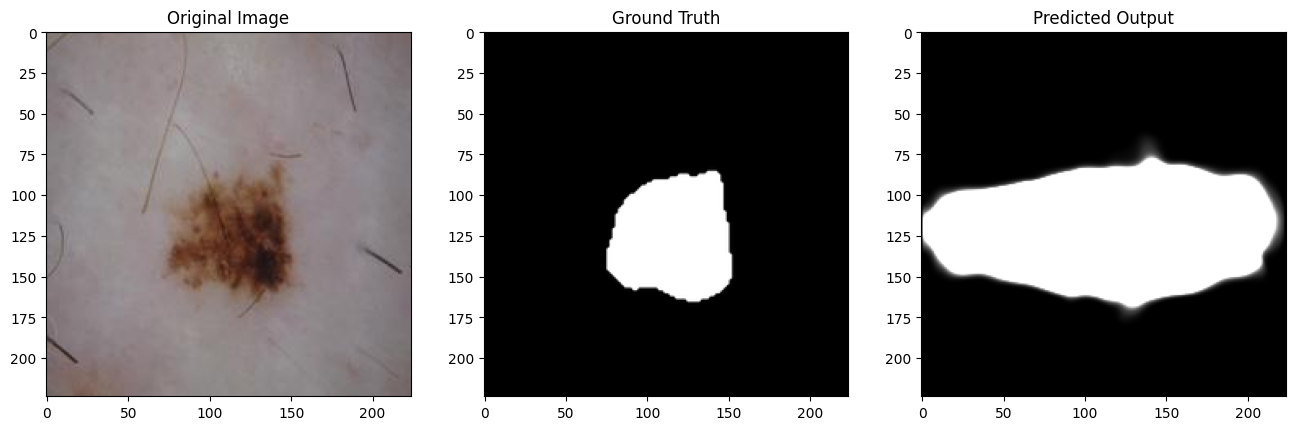

In [48]:
img_num = 941
img_pred = model.predict(X_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


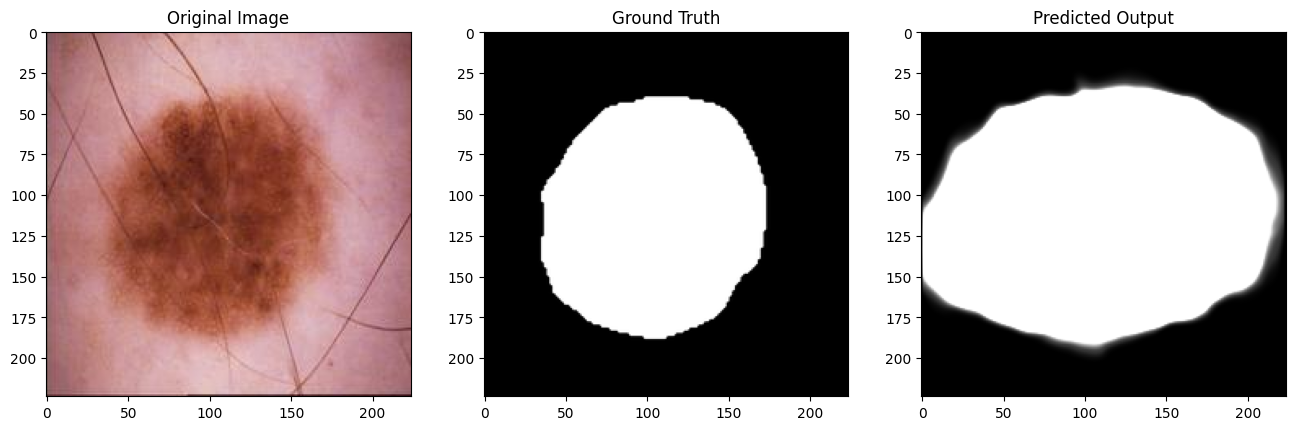

In [47]:
img_num = 415
img_pred = model.predict(X_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


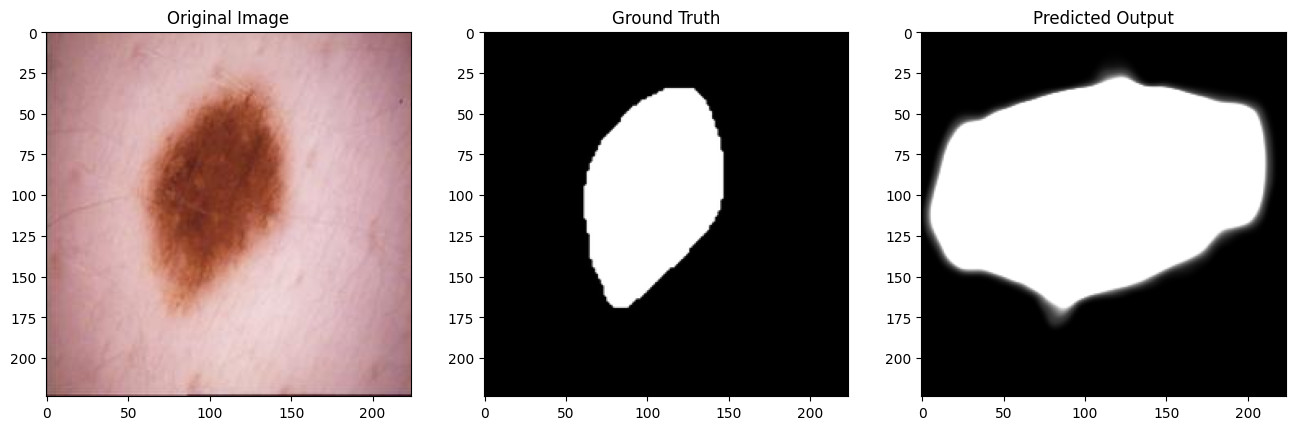

In [46]:
img_num = 210
img_pred = model.predict(X_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy

def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

def unet_transfer_learning(weights_path, epochs_num, savename):

    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)

    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")

    # Load pre-trained weights
    model.load_weights(weights_path)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.003),
                  loss=[jaccard_distance],
                  metrics=[iou, dice_coe,Precision(), Recall(), accuracy])
    

    model.summary()

    # Define checkpoint to save the best model
    checkpoint = ModelCheckpoint(savename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    # Train the model
    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=18, 
                     validation_data=(x_val, y_val), verbose=1,
                     callbacks=callbacks_list)

    # Save the trained model
    model.save('/kaggle/working/'+savename)

    return model, hist

In [42]:
weights_path = '/kaggle/input/unet-isic2018/unet_50_epoch.keras'  # Path to the pre-trained weights
epochs_num = 50  # Number of epochs for fine-tuning
savename = 'retrain_unet_100_ep.keras'  # Path to save the trained model

# Call the function
model, history = unet_transfer_learning(weights_path, epochs_num, savename)

Model: "UNET_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_46[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 224, 224,  │          0 │ activation_47[0]… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 112, 112,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_48[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 112, 112,  │          0 │ activation_49[0]… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 56, 56,    │          0 │ spatial_dropout2

 Total params: 31,466,753 (120.04 MB)

 Trainable params: 31,454,721 (119.99 MB)

 Non-trainable params: 12,032 (47.00 KB)

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7218 - dice_coe: 1.2828 - iou: 0.4537 - loss: 0.5463 - precision_2: 0.7169 - recall_2: 0.6074
Epoch 1: val_loss improved from inf to 0.54023, saving model to retrain_unet_100_ep.keras
346/346 ━━━━━━━━━━━━━━━━━━━━ 136s 284ms/step - accuracy: 0.7218 - dice_coe: 1.2828 - iou: 0.4537 - loss: 0.5463 - precision_2: 0.7169 - recall_2: 0.6074 - val_accuracy: 0.7062 - val_dice_coe: 1.3713 - val_iou: 0.4598 - val_loss: 0.5402 - val_precision_2: 0.6699 - val_recall_2: 0.6539
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7236 - dice_coe: 1.2593 - iou: 0.4489 - loss: 0.5511 - precision_2: 0.7203 - recall_2: 0.5945
Epoch 2: val_loss did not improve from 0.54023
346/346 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - accuracy: 0.7236 - dice_coe: 1.2592 - iou: 0.4489 - loss: 0.5511 - precision_2: 0.7203 - recall_2: 0.5945 - val_accuracy: 0.7058 - val_dice_coe: 1.2785 - val_iou: 0.4597 - val_loss: 0.5403 - val_precision_2: 

In [43]:
model = Model(inputs, pred, name="UNET_224")
model.compile(optimizer=Adam(learning_rate=0.003),
                  loss=[jaccard_distance],
                  metrics=[iou, dice_coe,Precision(), Recall(), accuracy])

In [44]:
model.load_weights('/kaggle/working/retrain_unet_100_ep.keras')

In [45]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model.evaluate(X_test, Y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

346/346 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.6681 - dice_coe: 1.4539 - iou: 0.4462 - loss: 0.5538 - precision_3: 0.6091 - recall_3: 0.7033
________________________
IOU:       |   45.03  |
Dice Coef: |   145.46  |
Precision: |   60.89  |
Recall:    |   70.40  |
Accuracy:  |   67.09  |
Loss:      |   54.97  |
________________________

-------------On Test  Set--------------------------

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.5978 - dice_coe: 1.3884 - iou: 0.3659 - loss: 0.6341 - precision_3: 0.6213 - recall_3: 0.6624
________________________
IOU:       |   36.36  |
Dice Coef: |   130.91  |
Precision: |   61.30  |
Recall:    |   61.35  |
Accuracy:  |   59.32  |
Loss:      |   63.64  |
________________________

-------------On validation Set---------------------

87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6896 - dice_coe: 1.4269 - iou: 0.4770 